In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import msprime
import seaborn as sns
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from aTMi.processing import optimized_block_sum
from aTMi.processing import obtain_densities
from aTMi.processing import obtain_mutation_densities
from aTMi.processing import calculate_transition_matrix
from aTMi.processing import read_file

from tqdm.notebook import tqdm
import logging
import torch
from aTMi.model import CoalescenceTransformer, num_params
from aTMi.training import train_model, test_model

from aTMi.config import population_times
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import msprime
from torch.utils.data import DataLoader
criterion = torch.nn.MSELoss()

population_time = population_times('arabidopsis_methyl')

/home/ubuntu/miniconda/envs/aTMi/lib/python3.9/site-packages/x_transformers/x_transformers.py:507: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/ubuntu/miniconda/envs/aTMi/lib/python3.9/site-packages/x_transformers/x_transformers.py:531: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [6]:
def create_sawtooth_demogaphy_object(Ne = 10**4, magnitue=2):
    demography = msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None,growth_rate=6437.7516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0,initial_size=Ne)
    return demography

In [7]:
import torch.nn as nn
from x_transformers import Encoder

class CoalescenceTransformer(nn.Module):
    def __init__(self, seq_len, enc_dim, enc_depth,
                 enc_heads, in_dim, out_dim, sum_encoder_dim=True):
        super().__init__()
        self.sum_encoder_dim = sum_encoder_dim
        self.inp = nn.Linear(in_dim, enc_dim)
        self.encoder = Encoder(
            dim=enc_dim, depth=enc_depth,
            heads=enc_heads,ff_glu=True,
            residual_attn=True,
            rotary_pos_emb=True)
        self.out = nn.Linear(enc_dim, out_dim)
    def forward(self, x):
        x = self.inp(x)
        x = self.encoder(x)
        if self.sum_encoder_dim: x = x.sum(dim=1)
        return self.out(x)

few_params = {
    'seq_len': None,
    'enc_dim': 512,
    'enc_depth': 12, 
    'enc_heads': 10, 
    'in_dim': 42,
    'out_dim': 42
}

model = CoalescenceTransformer(**few_params)
device = torch.device("cuda")
model = model.to(device)

/tmp/ipykernel_451028/2476352961.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(329.3814)
tensor(0.0700, device='cuda:0')
TM sum: 329.38140869140625


/tmp/ipykernel_451028/2476352961.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(344.4897)
tensor(0.1022, device='cuda:0')
TM sum: 344.48968505859375


/tmp/ipykernel_451028/2476352961.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(312.3982)
tensor(0.0783, device='cuda:0')
TM sum: 312.3981628417969


/tmp/ipykernel_451028/2476352961.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(332.3421)
tensor(0.0824, device='cuda:0')
TM sum: 332.3421325683594


/tmp/ipykernel_451028/2476352961.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(329.9772)
tensor(0.1061, device='cuda:0')
TM sum: 329.9772033691406


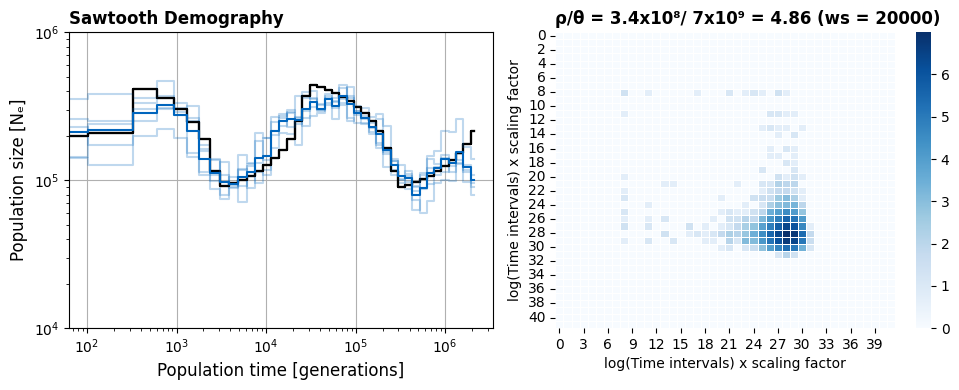

In [8]:
empirical_scaling_factor = np.exp(8.2)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]

y_preds = []
model_idx = 26
for seed in [1000, 2000, 3000, 4000, 5000]: #, 2000, 3000, 4000, 5000:

    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(model_idx) + ".pth")['model'])
    model_idx += 1
    sawtooth_demography_object = create_sawtooth_demogaphy_object(Ne = 2*10**5, magnitue=8)

    # simulation of data
    params = {'discrete_genome': True, 'samples': 10, 
        'ploidy': 1, 'demography': sawtooth_demography_object,
        'recombination_rate': 3.4e-8, 'random_seed': seed,'sequence_length': 4_000_000
    }
    ts = msprime.sim_ancestry(**params)
    ts = msprime.mutate(ts, rate=7e-9 * 1)
    debugger = msprime.DemographyDebugger()
    debugger = msprime.DemographyDebugger(demography=sawtooth_demography_object)
    population_size = debugger.population_size_trajectory(population_time).flatten()

    # formatting of data for the model
    window_size = 20_000
    
    mutation_densities = obtain_mutation_densities(ts, window_size=window_size)
    tm = np.log(calculate_transition_matrix(np.log((mutation_densities.flatten()+1)*empirical_scaling_factor),
                                            np.log(population_time+1)) + 1)
    population_size_log = np.log(population_size)
    tm = torch.tensor(tm, dtype=torch.float32)
    print(tm.sum())
    population_size_log = torch.tensor(population_size_log, dtype=torch.float32)

    # loading it in dataloader and running hte inference
    inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)
    model.eval()
    total_loss = 0
    total_samples = 0 
    with torch.no_grad():
        for inputs, targets in inf_dl:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            print(loss)
            break

    # extractin the output
    y_true = targets.detach().cpu().numpy()
    y_pred = predictions.detach().cpu().numpy()

    # plotting it
    idx = 0
    sns.lineplot(x=population_time, y=np.exp(y_true[idx]), drawstyle="steps-mid", ax=ax, c="black", alpha=0.75)
    sns.lineplot(x=population_time, y=np.exp(y_pred[idx]), drawstyle="steps-mid", ax=ax, c="#0065bd", alpha=0.25)
    ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
    y_preds.append(y_pred[idx])

    ax.set_ylabel("Population size [Nₑ]", fontsize=12)
    ax.set_xlabel("Population time [generations]", fontsize=12)
    ax.set_title(f"Sawtooth Demography", loc="left", fontsize=12, fontweight='bold')
    ax.grid(True)
    print(f"TM sum: {tm.sum()}")

sns.lineplot(x=population_time, y=np.exp(np.array(y_preds).mean(0)), drawstyle="steps-mid", ax=ax, c="#0065bd")


ax = axs[1]
ax_labels = [f'Time {i}' for i in range(1, len(population_time) + 1)]
sns.heatmap(tm, cmap="Blues", annot=False, fmt=".2f", linewidths=.5, ax=ax)
ax.set_xlabel("log(Time intervals) x scaling factor")
ax.set_ylabel("log(Time intervals) x scaling factor")
ax.set_title(f"ρ/θ = 3.4x10⁸/ 7x10⁹ = 4.86 (ws = {window_size})", fontsize=12,  fontweight='bold', loc="left")
plt.tight_layout()
#plt.savefig("Sawtooth-10-Simulations-rhotheta-5-and-tm.png", dpi = 300)

In [9]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from copy import copy

In [10]:
def encode_minor_alleles_as_derived(alleles):
    allele_counts = Counter(alleles)
    min_allele = min(allele_counts, key=allele_counts.get)
    return [1 if allele == min_allele else 0 for allele in alleles]

def real_data2genotype_matrix_and_positions(data):
    num_segregating_sites = data.shape[0]
    for i in range(num_segregating_sites):
        data.loc[i,'alleles'] = str(encode_minor_alleles_as_derived(data['alleles'][i]))
    data = data[['chr', 'pos', 'alleles']]
    
    expanded_data = []
    for index, row in data.iterrows():
        chromosome = row['chr']
        position = row['pos']
        alleles = row['alleles'][1:-1].split(', ')  
        new_row = [chromosome, position] + alleles
        expanded_data.append(new_row)
    headers = ['chr', 'pos'] + [f'{i}' for i in range(len(alleles))]
    expanded_df = pd.DataFrame(expanded_data, columns=headers)
    
    positions = expanded_df['pos'].tolist()
    genotype_matrix = np.array(expanded_df.iloc[:, 2:].T).astype(np.int32)
    assert len(expanded_df['chr'].unique()) == 1
    return genotype_matrix, np.array(positions)

def real_genotype_matrix2transition_matrix(genotype_matrix, sequence_start, sequence_end , positions, window_size, num_samples = 10):
    empirical_scaling_factor = np.exp(8.2)
    mask = np.logical_and(positions >= sequence_start, positions < sequence_end)

    genotype_matrix = genotype_matrix[:, mask]
    positions = positions[mask]

    combinations = binomial_combinations_k2(num_samples)
    sequence_length = int(sequence_end-sequence_start)
    Xs = []
    for sample_0, sample_1 in combinations:
        binary_genotype_matrix = genotype_matrix[[sample_0, sample_1]]

        sum_matrix = binary_genotype_matrix.sum(0)
        valid_mask = (sum_matrix < 2) & (sum_matrix > 0)
        binary_genotype_matrix = binary_genotype_matrix[:, valid_mask]
        binary_positions = positions[valid_mask]
        #print(binary_positions)

        full_sequence = np.zeros((2, int(sequence_length)), dtype=np.int32)
        full_sequence[:, binary_positions-int(sequence_start)] = binary_genotype_matrix
        #print(full_sequence.sum())
        X = obtain_densities(full_sequence, window_size=window_size)
        Xs.append(X)
    mutation_densities = torch.stack(Xs)
    tm = np.log(calculate_transition_matrix(np.log((mutation_densities.flatten()+1)*empirical_scaling_factor),
                                        np.log(population_time+1)) + 1)
    tm = torch.tensor(tm, dtype=torch.float32)
    return tm

def real_genotype_matrix2mutation_sequence(genotype_matrix, sequence_start, sequence_end , positions, window_size, num_samples = 10):
    empirical_scaling_factor = 3
    mask = np.logical_and(positions >= sequence_start, positions < sequence_end)

    genotype_matrix = genotype_matrix[:, mask]
    positions = positions[mask]

    combinations = binomial_combinations_k2(num_samples)
    sequence_length = int(sequence_end-sequence_start)
    Xs = []
    for sample_0, sample_1 in combinations:
        binary_genotype_matrix = genotype_matrix[[sample_0, sample_1]]

        sum_matrix = binary_genotype_matrix.sum(0)
        valid_mask = (sum_matrix < 2) & (sum_matrix > 0)
        binary_genotype_matrix = binary_genotype_matrix[:, valid_mask]
        binary_positions = positions[valid_mask]
        #print(binary_positions)

        full_sequence = np.zeros((2, int(sequence_length)), dtype=np.int32)
        full_sequence[:, binary_positions-int(sequence_start)] = binary_genotype_matrix
        #print(full_sequence.sum())
        X = obtain_densities(full_sequence, window_size=window_size)
        Xs.append(X)
    mutation_densities = torch.stack(Xs)
    return mutation_densities



In [11]:
#data_ibnr_5mb_1 = pd.read_csv("./Athaliana/ibnr_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_ceu_5mb_1 = pd.read_csv("./Athaliana/ceu_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

In [59]:
# maf
data_ibnr_5mb_1 = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ceu_5mb_1 = pd.read_csv("./Athaliana_maf/ceu_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

In [13]:
def real_genotype_matrix2transition_matrix(genotype_matrix, sequence_start, sequence_end , positions, window_size, num_samples = 10):
    empirical_scaling_factor = np.exp(8.2)
    mask = np.logical_and(positions >= sequence_start, positions < sequence_end)

    genotype_matrix = genotype_matrix[:, mask]
    positions = positions[mask]

    combinations = binomial_combinations_k2(num_samples)
    sequence_length = int(sequence_end-sequence_start)
    Xs = []
    for sample_0, sample_1 in combinations:
        binary_genotype_matrix = genotype_matrix[[sample_0, sample_1]]

        sum_matrix = binary_genotype_matrix.sum(0)
        valid_mask = (sum_matrix < 2) & (sum_matrix > 0)
        binary_genotype_matrix = binary_genotype_matrix[:, valid_mask]
        binary_positions = positions[valid_mask]
        #print(binary_positions)

        full_sequence = np.zeros((2, int(sequence_length)), dtype=np.int32)
        full_sequence[:, binary_positions-int(sequence_start)] = binary_genotype_matrix
        #print(full_sequence.sum())
        X = obtain_densities(full_sequence, window_size=window_size)
        Xs.append(X)
    mutation_densities = torch.stack(Xs)
    mutation_densities = mutation_densities.flatten()
    #mutation_densities = mutation_densities[mutation_densities>0]
    tm = np.log(calculate_transition_matrix(np.log((mutation_densities.flatten()+1)*empirical_scaling_factor),
                                        np.log(population_time+1)) + 1)
    #tm = np.log(calculate_transition_matrix(np.log(mutation_densities+1)*empirical_scaling_factor, np.log(population_time+1)) + 1)
    tm = torch.tensor(tm, dtype=torch.float32)
    return tm

In [60]:
gm_ibnr_5mb_1, positions_ibnr_5mb_1 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_1)
#gm_ibnr_5mb_2, positions_ibnr_5mb_2 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_2)
#gm_ibnr_5mb_3, positions_ibnr_5mb_3 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_3)
#gm_ibnr_5mb_4, positions_ibnr_5mb_4 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_4)
#gm_ibnr_5mb_5, positions_ibnr_5mb_5 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_5)
gm_ceu_5mb_1, positions_ceu_5mb_1 = real_data2genotype_matrix_and_positions(data_ceu_5mb_1)
#gm_ceu_5mb_2, positions_ceu_5mb_2 = real_data2genotype_matrix_and_positions(data_ceu_5mb_2)
#gm_ceu_5mb_3, positions_ceu_5mb_3 = real_data2genotype_matrix_and_positions(data_ceu_5mb_3)
#gm_ceu_5mb_4, positions_ceu_5mb_4 = real_data2genotype_matrix_and_positions(data_ceu_5mb_4)
#gm_ceu_5mb_5, positions_ceu_5mb_5 = real_data2genotype_matrix_and_positions(data_ceu_5mb_5)



In [15]:
sequence_starts = [0]
sequence_ends = [2e6]

In [16]:
sequence_starts = [0, 2e6, 4e6]
sequence_ends = [2e6, 4e6, 6e6]

In [61]:
np.random.seed(100)
sequence_starts = []
sequence_ends = []
for i in range(20):
    start = int(np.random.uniform(0, 28e6))
    sequence_starts.append(start)
    #end = start+np.random.uniform(0.75e6, 1.25e6)
    end = start+np.random.uniform(1e6, 3e6)

   # end = start+1e6
    #end = start+1.5e6
    
    print(start, end)
    sequence_ends.append(int(end))

15215338 16772076.770187592
11886492 14576044.264639808
132127 1375265.2415662284
18780974 21432679.510210097
3827784 5977970.658854499
24957014 26375418.24423438
5189190 6405943.78092851
6151529 9108776.569414739
22727128 24071010.02546519
22854292 24402439.494083397
12087717 14967776.63924475
22894182 24566405.900241796
4911492 6657156.092579846
159278 1664130.7068896808
22278550 23309059.94249268
16767614 18975223.078085706
2944135 4708021.88988622
1021329 3802152.1268841513
27465783 28585666.977636073
24935286 27089088.998800065


In [18]:
from aTMi.misc import binomial_combinations_k2

In [63]:

y_preds_chromosomes_models = []
seq_samples_snp_ibnr = []

for i in range(36, 40):
    model_idx = i 
    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(model_idx) + ".pth")['model'])
    y_preds_chromosomes = []
    #for gm, position in [(gm_ibnr_5mb_1, positions_ibnr_5mb_1),
    #                    (gm_ibnr_5mb_2, positions_ibnr_5mb_2), 
    #                    (gm_ibnr_5mb_3, positions_ibnr_5mb_3),
    #                    (gm_ibnr_5mb_4, positions_ibnr_5mb_4),
    #                    (gm_ibnr_5mb_5, positions_ibnr_5mb_5)
    #                    ]:
    for gm, position in [(gm_ibnr_5mb_1, positions_ibnr_5mb_1)]:
        tms = []
        for i in range(len(sequence_starts)):
            sequence_start, sequence_end = sequence_starts[i],sequence_ends[i]
            tm_smp = real_genotype_matrix2transition_matrix(
                gm,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=position,
                window_size=20_000, num_samples=10)
            print(tm_smp.sum())
            seq_samples_snp_ibnr.append(tm_smp.sum().item())

            #if tm_smp.sum() > 200:
            tms.append(tm_smp)
        y_preds = [] 
        for tm in tms:
            tm = torch.tensor(tm, dtype=torch.float32)
            population_size_log = torch.tensor(0, dtype=torch.float32)
            inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)


            model.eval()
            total_loss = 0
            total_samples = 0 
            with torch.no_grad():
                for inputs, targets in inf_dl:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    predictions = model(inputs)
                    break

            y_pred = predictions.detach().cpu().numpy()[0]
            y_preds.append(y_pred) 

        y_preds_chromosomes.append(y_preds)
    y_preds_chromosomes_models.append(y_preds_chromosomes)

y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(0)
y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(1)
y_preds_chromosomes_ibnr_snp = y_preds_chromosomes_models


y_preds_chromosomes_models = []
seq_samples_snp_ceu = []

for i in range(36, 40):
    model_idx = i 
    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(model_idx) + ".pth")['model'])
    y_preds_chromosomes = []
    #for gm, position in [(gm_ceu_5mb_1, positions_ceu_5mb_1),
    #                    (gm_ceu_5mb_2, positions_ceu_5mb_2), 
    #                    (gm_ceu_5mb_3, positions_ceu_5mb_3),
    #                    (gm_ceu_5mb_4, positions_ceu_5mb_4),
    #                    (gm_ceu_5mb_5, positions_ceu_5mb_5)
    #                    ]:
    for gm, position in [(gm_ceu_5mb_1, positions_ceu_5mb_1)]:
        tms = []
        for i in range(len(sequence_starts)):
            sequence_start, sequence_end = sequence_starts[i],sequence_ends[i]
            tm_smp = real_genotype_matrix2transition_matrix(
                gm,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=position,
                window_size=20_000, num_samples=10)
            print(tm_smp.sum())
            seq_samples_snp_ceu.append(tm_smp.sum().item())
            #if tm_smp.sum() > 200:
            tms.append(tm_smp)

        y_preds = [] 
        for tm in tms:
            tm = torch.tensor(tm, dtype=torch.float32)
            population_size_log = torch.tensor(0, dtype=torch.float32)
            inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)


            model.eval()
            total_loss = 0
            total_samples = 0 
            with torch.no_grad():
                for inputs, targets in inf_dl:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    predictions = model(inputs)
                    break

            y_pred = predictions.detach().cpu().numpy()[0]
            y_preds.append(y_pred) 

        y_preds_chromosomes.append(y_preds)
    y_preds_chromosomes_models.append(y_preds_chromosomes)

y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(0)
y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(1)
y_preds_chromosomes_ceu_snp = y_preds_chromosomes_models

/tmp/ipykernel_451028/3913668811.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(680.6281)
tensor(1027.3949)
tensor(693.6448)
tensor(1083.9752)
tensor(998.0862)
tensor(751.5959)
tensor(733.1781)
tensor(1133.2847)
tensor(674.7066)
tensor(727.0209)
tensor(986.0006)
tensor(756.7318)
tensor(921.9894)
tensor(775.3396)
tensor(554.4330)
tensor(817.0941)
tensor(905.9173)
tensor(1063.7197)
tensor(645.4538)
tensor(978.4241)


/tmp/ipykernel_451028/3913668811.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tm = torch.tensor(tm, dtype=torch.float32)


tensor(680.6281)
tensor(1027.3949)
tensor(693.6448)
tensor(1083.9752)
tensor(998.0862)
tensor(751.5959)
tensor(733.1781)
tensor(1133.2847)
tensor(674.7066)
tensor(727.0209)
tensor(986.0006)
tensor(756.7318)
tensor(921.9894)
tensor(775.3396)
tensor(554.4330)
tensor(817.0941)
tensor(905.9173)
tensor(1063.7197)
tensor(645.4538)
tensor(978.4241)
tensor(680.6281)
tensor(1027.3949)
tensor(693.6448)
tensor(1083.9752)
tensor(998.0862)
tensor(751.5959)
tensor(733.1781)
tensor(1133.2847)
tensor(674.7066)
tensor(727.0209)
tensor(986.0006)
tensor(756.7318)
tensor(921.9894)
tensor(775.3396)
tensor(554.4330)
tensor(817.0941)
tensor(905.9173)
tensor(1063.7197)
tensor(645.4538)
tensor(978.4241)
tensor(680.6281)
tensor(1027.3949)
tensor(693.6448)
tensor(1083.9752)
tensor(998.0862)
tensor(751.5959)
tensor(733.1781)
tensor(1133.2847)
tensor(674.7066)
tensor(727.0209)
tensor(986.0006)
tensor(756.7318)
tensor(921.9894)
tensor(775.3396)
tensor(554.4330)
tensor(817.0941)
tensor(905.9173)
tensor(1063.7197)
te

/tmp/ipykernel_451028/3913668811.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff

tensor(591.8638)
tensor(990.6689)
tensor(593.2538)
tensor(986.5823)
tensor(870.0166)
tensor(645.7958)
tensor(617.3999)
tensor(965.6187)
tensor(542.1883)
tensor(546.8497)
tensor(956.5992)
tensor(573.8398)
tensor(753.6250)
tensor(678.0867)
tensor(466.5698)
tensor(734.7521)
tensor(822.9187)
tensor(991.3089)
tensor(616.0751)
tensor(822.3544)


/tmp/ipykernel_451028/3913668811.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tm = torch.tensor(tm, dtype=torch.float32)


tensor(591.8638)
tensor(990.6689)
tensor(593.2538)
tensor(986.5823)
tensor(870.0166)
tensor(645.7958)
tensor(617.3999)
tensor(965.6187)
tensor(542.1883)
tensor(546.8497)
tensor(956.5992)
tensor(573.8398)
tensor(753.6250)
tensor(678.0867)
tensor(466.5698)
tensor(734.7521)
tensor(822.9187)
tensor(991.3089)
tensor(616.0751)
tensor(822.3544)
tensor(591.8638)
tensor(990.6689)
tensor(593.2538)
tensor(986.5823)
tensor(870.0166)
tensor(645.7958)
tensor(617.3999)
tensor(965.6187)
tensor(542.1883)
tensor(546.8497)
tensor(956.5992)
tensor(573.8398)
tensor(753.6250)
tensor(678.0867)
tensor(466.5698)
tensor(734.7521)
tensor(822.9187)
tensor(991.3089)
tensor(616.0751)
tensor(822.3544)
tensor(591.8638)
tensor(990.6689)
tensor(593.2538)
tensor(986.5823)
tensor(870.0166)
tensor(645.7958)
tensor(617.3999)
tensor(965.6187)
tensor(542.1883)
tensor(546.8497)
tensor(956.5992)
tensor(573.8398)
tensor(753.6250)
tensor(678.0867)
tensor(466.5698)
tensor(734.7521)
tensor(822.9187)
tensor(991.3089)
tensor(616.075

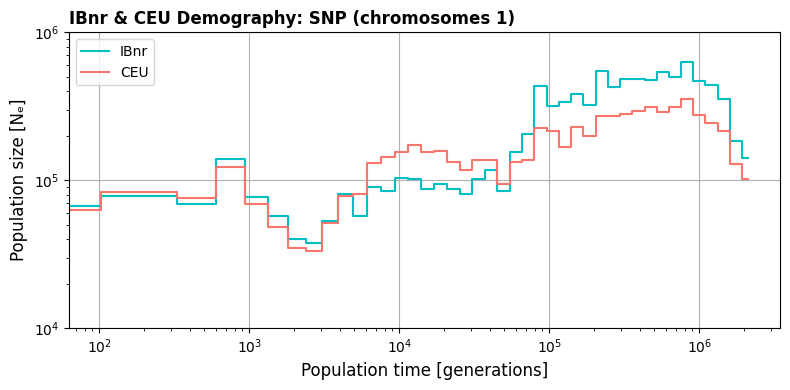

In [20]:
fig, ax = plt.subplots(1, figsize=(8, 4))

for i in range(1):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_snp[i]), drawstyle="steps-mid", ax=ax, c="#00BFC4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
ax.set_title(f"IBnr & CEU Demography: SNP (chromosomes 1)", loc="left", fontsize=12, fontweight='bold')
ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_snp.mean(0)), drawstyle="steps-mid", ax=ax, c="#00BFC4",  label="IBnr")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(1):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_snp[i]), drawstyle="steps-mid", ax=ax, c="#F8766D", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
ax.set_title(f"IBnr & CEU Demography: SNP (chromosomes 1)", loc="left", fontsize=12, fontweight='bold')
ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_snp.mean(0)), drawstyle="steps-mid", ax=ax, c="#F8766D",  label="CEU")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))


ax.grid()
plt.tight_layout()


In [46]:
# newest MAF stuff MAF
data_ibnr_5mb_1 = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ibnr_5mb_2 = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_2", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ibnr_5mb_3 = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_3", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ibnr_5mb_4 = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_4", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ibnr_5mb_5 = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_5", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ceu_5mb_1 = pd.read_csv("./Athaliana_maf/ceu_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ceu_5mb_2 = pd.read_csv("./Athaliana_maf/ceu_multihetsep_smps_5mb_2", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ceu_5mb_3 = pd.read_csv("./Athaliana_maf/ceu_multihetsep_smps_5mb_3", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ceu_5mb_4 = pd.read_csv("./Athaliana_maf/ceu_multihetsep_smps_5mb_4", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_ceu_5mb_5 = pd.read_csv("./Athaliana_maf/ceu_multihetsep_smps_5mb_5", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

In [47]:
gm_ibnr_5mb_1, positions_ibnr_5mb_1 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_1)
gm_ibnr_5mb_2, positions_ibnr_5mb_2 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_2)
gm_ibnr_5mb_3, positions_ibnr_5mb_3 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_3)
gm_ibnr_5mb_4, positions_ibnr_5mb_4 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_4)
gm_ibnr_5mb_5, positions_ibnr_5mb_5 = real_data2genotype_matrix_and_positions(data_ibnr_5mb_5)
gm_ceu_5mb_1, positions_ceu_5mb_1 = real_data2genotype_matrix_and_positions(data_ceu_5mb_1)
gm_ceu_5mb_2, positions_ceu_5mb_2 = real_data2genotype_matrix_and_positions(data_ceu_5mb_2)
gm_ceu_5mb_3, positions_ceu_5mb_3 = real_data2genotype_matrix_and_positions(data_ceu_5mb_3)
gm_ceu_5mb_4, positions_ceu_5mb_4 = real_data2genotype_matrix_and_positions(data_ceu_5mb_4)
gm_ceu_5mb_5, positions_ceu_5mb_5 = real_data2genotype_matrix_and_positions(data_ceu_5mb_5)

In [48]:
gm_ibnr_5mb_1.shape, gm_ibnr_5mb_2.shape, gm_ibnr_5mb_3.shape, gm_ibnr_5mb_4.shape, gm_ibnr_5mb_5.shape

np.random.seed(1000)
sequence_starts = []
sequence_ends = []
for i in range(10):
    start = np.random.uniform(0, 1.5e6)
    sequence_starts.append(start)
    #sequence_ends.append(start+np.random.uniform(0.75e6, 1.25e6))
    sequence_ends.append(start+np.random.uniform(2e6))

In [49]:
sequence_starts = [0, 0, 0, 0] + [1, 1, 1, 1]
sequence_ends = [1e6, 1.25e6, 1.5e6, 2e6] + [2e6, 2.25e6, 2.5e6, 3e6]


np.random.seed(100)
sequence_starts = []
sequence_ends = []
for i in range(20):
    start = int(np.random.uniform(0, 0.5e6))
    sequence_starts.append(start)
    #end = start+np.random.uniform(0.75e6, 1.25e6)
    end = start+np.random.uniform(1e6, 3e6)

   # end = start+1e6
    #end = start+1.5e6
    
    print(start, end)
    sequence_ends.append(int(end))

271702 1828440.7701875924
212258 2901810.2646398074
2359 1245497.2415662284
335374 2987079.510210095
68353 2218539.6588545
445660 1864064.2442343791
92664 1309417.7809285102
109848 3067095.5694147395
405841 1749723.0254651885
408112 1956259.4940833985
215852 3095911.639244749
408824 2081047.9002417973
87705 1833369.0925798463
2844 1507696.7068896808
397831 1428340.942492678
299421 2507030.0780857075
52573 1816459.88988622
18238 2799061.1268841513
490460 1610343.9776360744
445272 2599074.998800066


In [50]:
y_preds_chromosomes_models = []
seq_samples_ibnr = []

for i in range(36, 40):
    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(i) + ".pth")['model'])
    y_preds_chromosomes = []
    for gm, position in [(gm_ibnr_5mb_1, positions_ibnr_5mb_1),
                        (gm_ibnr_5mb_2, positions_ibnr_5mb_2), 
                        (gm_ibnr_5mb_3, positions_ibnr_5mb_3),
                        (gm_ibnr_5mb_4, positions_ibnr_5mb_4),
                        (gm_ibnr_5mb_5, positions_ibnr_5mb_5)
                        ]:
        tms = []
        for i in range(len(sequence_starts)):
            sequence_start, sequence_end = sequence_starts[i],sequence_ends[i]+2
            tm_smp = real_genotype_matrix2transition_matrix(
                gm,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=position,
                window_size=20_000, num_samples=10)
            print(tm_smp.sum().item())
            seq_samples_ibnr.append(tm_smp.sum().item())
            #if tm_smp.sum() > 200:
            tms.append(tm_smp)
        y_preds = [] 
        for tm in tms:
            tm = torch.tensor(tm, dtype=torch.float32)
            population_size_log = torch.tensor(0, dtype=torch.float32)
            inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)


            model.eval()
            total_loss = 0
            total_samples = 0 
            with torch.no_grad():
                for inputs, targets in inf_dl:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    predictions = model(inputs)
                    break

            y_pred = predictions.detach().cpu().numpy()[0]
            y_preds.append(y_pred) 

        y_preds_chromosomes.append(y_preds)
    y_preds_chromosomes_models.append(y_preds_chromosomes)

y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(0)
y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(1)
y_preds_chromosomes_ibnr_smp = y_preds_chromosomes_models

/tmp/ipykernel_451028/444093590.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_c

738.80615234375
930.2205810546875
619.736083984375
937.715087890625
804.6070556640625
644.723388671875
595.0611572265625
954.4720458984375
633.0491943359375
705.653564453125
985.0924072265625
740.824462890625
720.17041015625
672.434326171875
547.0079345703125
792.5458374023438
761.1505126953125
866.7072143554688
620.3699951171875
793.417236328125


/tmp/ipykernel_451028/444093590.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tm = torch.tensor(tm, dtype=torch.float32)


660.6279907226562
912.3341674804688
554.4609985351562
847.1571655273438
744.1400146484375
647.8353271484375
551.9618530273438
938.2345581054688
635.9459228515625
636.171630859375
898.4345092773438
676.9314575195312
674.6888427734375
600.9652099609375
467.8146057128906
760.3930053710938
707.798583984375
830.3121337890625
527.39208984375
771.8825073242188
719.4498901367188
961.1942138671875
509.7021179199219
913.3901977539062
815.230224609375
663.9656982421875
494.7880859375
1001.8294677734375
591.4873046875
705.012451171875
972.0321655273438
731.6806030273438
704.8712768554688
563.7636108398438
457.6669006347656
820.2600708007812
726.69384765625
898.009521484375
604.9429321289062
866.6181030273438
535.290283203125
729.2725219726562
545.860595703125
666.1536865234375
626.2196044921875
567.2007446289062
575.4880981445312
745.6979370117188
531.510498046875
528.5330200195312
731.602294921875
524.5454711914062
596.1182861328125
615.0087890625
442.2105407714844
693.711181640625
648.6004028320

In [51]:
y_preds_chromosomes_models = []
seq_samples_ceu = []

for i in range(36, 40):
    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(i) + ".pth")['model'])
    y_preds_chromosomes = []
    for gm, position in [(gm_ceu_5mb_1, positions_ceu_5mb_1),
                        (gm_ceu_5mb_2, positions_ceu_5mb_2), 
                        (gm_ceu_5mb_3, positions_ceu_5mb_3),
                        (gm_ceu_5mb_4, positions_ceu_5mb_4),
                        (gm_ceu_5mb_5, positions_ceu_5mb_5)
                        ]:
        tms = []
        for i in range(len(sequence_starts)):
            sequence_start, sequence_end = sequence_starts[i],sequence_ends[i]-1
            tm_smp = real_genotype_matrix2transition_matrix(
                gm,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=position,
                window_size=20_000, num_samples=10)
            print(tm_smp.sum())
            seq_samples_ceu.append(tm_smp.sum().item())

            #if tm_smp.sum() > 200:
            tms.append(tm_smp)

        y_preds = [] 
        for tm in tms:
            tm = torch.tensor(tm, dtype=torch.float32)
            population_size_log = torch.tensor(0, dtype=torch.float32)
            inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)


            model.eval()
            total_loss = 0
            total_samples = 0 
            with torch.no_grad():
                for inputs, targets in inf_dl:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    predictions = model(inputs)
                    break

            y_pred = predictions.detach().cpu().numpy()[0]
            y_preds.append(y_pred) 

        y_preds_chromosomes.append(y_preds)
    y_preds_chromosomes_models.append(y_preds_chromosomes)

y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(0)
y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(1)
y_preds_chromosomes_ceu_smp = y_preds_chromosomes_models

/tmp/ipykernel_451028/285602042.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_c

tensor(691.0662)
tensor(861.2421)
tensor(573.2432)
tensor(901.2145)
tensor(747.6046)
tensor(610.4182)
tensor(559.0607)
tensor(874.0707)
tensor(587.0831)
tensor(657.9062)
tensor(934.6467)
tensor(681.9353)
tensor(670.8987)
tensor(632.0107)
tensor(548.5234)
tensor(763.8483)
tensor(729.2172)
tensor(848.5968)
tensor(586.5759)
tensor(740.5900)


/tmp/ipykernel_451028/285602042.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tm = torch.tensor(tm, dtype=torch.float32)


tensor(547.2212)
tensor(750.2635)
tensor(496.4034)
tensor(744.4830)
tensor(618.8549)
tensor(530.2469)
tensor(469.5115)
tensor(779.0432)
tensor(528.2468)
tensor(512.1314)
tensor(774.3442)
tensor(543.7650)
tensor(552.6852)
tensor(524.2998)
tensor(403.8416)
tensor(666.1851)
tensor(582.9103)
tensor(727.8894)
tensor(433.6500)
tensor(639.3925)
tensor(657.2928)
tensor(854.4761)
tensor(485.1846)
tensor(842.4669)
tensor(765.0110)
tensor(610.8924)
tensor(463.6546)
tensor(914.1658)
tensor(552.9472)
tensor(649.1869)
tensor(881.8380)
tensor(673.5330)
tensor(682.5590)
tensor(548.0778)
tensor(426.7380)
tensor(761.0535)
tensor(670.7338)
tensor(814.7825)
tensor(561.8148)
tensor(777.8889)
tensor(515.4141)
tensor(731.0651)
tensor(484.4121)
tensor(679.6849)
tensor(616.5427)
tensor(541.1154)
tensor(525.6101)
tensor(742.2924)
tensor(517.8027)
tensor(538.5532)
tensor(731.4017)
tensor(527.1026)
tensor(587.4967)
tensor(545.8608)
tensor(411.6496)
tensor(681.2597)
tensor(596.3446)
tensor(795.4578)
tensor(470.954

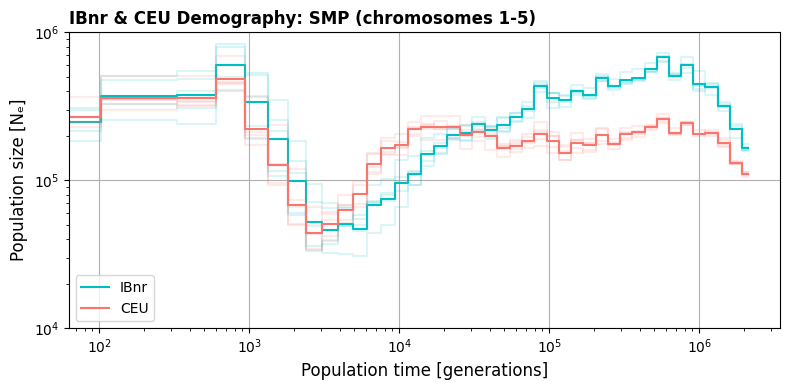

In [52]:
fig, ax = plt.subplots(1, figsize=(8, 4))

for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_smp[i]), drawstyle="steps-mid", ax=ax, c="#00BFC4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
ax.set_title(f"IBnr & CEU Demography: SNP (chromosomes 1-5)", loc="left", fontsize=12, fontweight='bold')
ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#00BFC4",  label="IBnr")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_smp[i]), drawstyle="steps-mid", ax=ax, c="#F8766D", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
ax.set_title(f"IBnr & CEU Demography: SMP (chromosomes 1-5)", loc="left", fontsize=12, fontweight='bold')
ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#F8766D",  label="CEU")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))


ax.grid()
plt.tight_layout()


In [53]:
# newest stuff no MAF

data_group11_smp_5mb_1 = pd.read_csv("./Bd/group1.1_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group11_smp_5mb_2 = pd.read_csv("./Bd/group1.1_multihetsep_smps_5mb_2", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group11_smp_5mb_3 = pd.read_csv("./Bd/group1.1_multihetsep_smps_5mb_3", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group11_smp_5mb_4 = pd.read_csv("./Bd/group1.1_multihetsep_smps_5mb_4", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group11_smp_5mb_5 = pd.read_csv("./Bd/group1.1_multihetsep_smps_5mb_5", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

data_group12_smp_5mb_1 = pd.read_csv("./Bd/group1.2_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group12_smp_5mb_2 = pd.read_csv("./Bd/group1.2_multihetsep_smps_5mb_2", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group12_smp_5mb_3 = pd.read_csv("./Bd/group1.2_multihetsep_smps_5mb_3", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group12_smp_5mb_4 = pd.read_csv("./Bd/group1.2_multihetsep_smps_5mb_4", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_group12_smp_5mb_5 = pd.read_csv("./Bd/group1.2_multihetsep_smps_5mb_5", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

In [54]:
# newest stuff MAF

#data_group11_smp_5mb_1 = pd.read_csv("./Bd_maf/group1.1_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group11_smp_5mb_2 = pd.read_csv("./Bd_maf/group1.1_multihetsep_smps_5mb_2", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group11_smp_5mb_3 = pd.read_csv("./Bd_maf/group1.1_multihetsep_smps_5mb_3", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group11_smp_5mb_4 = pd.read_csv("./Bd_maf/group1.1_multihetsep_smps_5mb_4", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group11_smp_5mb_5 = pd.read_csv("./Bd_maf/group1.1_multihetsep_smps_5mb_5", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

#data_group12_smp_5mb_1 = pd.read_csv("./Bd_maf/group1.2_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group12_smp_5mb_2 = pd.read_csv("./Bd_maf/group1.2_multihetsep_smps_5mb_2", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group12_smp_5mb_3 = pd.read_csv("./Bd_maf/group1.2_multihetsep_smps_5mb_3", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group12_smp_5mb_4 = pd.read_csv("./Bd_maf/group1.2_multihetsep_smps_5mb_4", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
#data_group12_smp_5mb_5 = pd.read_csv("./Bd_maf/group1.2_multihetsep_smps_5mb_5", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

In [55]:
gm_group_smp_5mb_1, positions_group_smp_5mb_1 = real_data2genotype_matrix_and_positions(data_group11_smp_5mb_1)
gm_group_smp_5mb_2, positions_group_smp_5mb_2 = real_data2genotype_matrix_and_positions(data_group11_smp_5mb_2)
gm_group_smp_5mb_3, positions_group_smp_5mb_3 = real_data2genotype_matrix_and_positions(data_group11_smp_5mb_3)
gm_group_smp_5mb_4, positions_group_smp_5mb_4 = real_data2genotype_matrix_and_positions(data_group11_smp_5mb_4)
gm_group_smp_5mb_5, positions_group_smp_5mb_5 = real_data2genotype_matrix_and_positions(data_group11_smp_5mb_5)

In [56]:

y_preds_chromosomes_models = []
seq_samples_11 = []

for i in range(36, 40):
    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(i) + ".pth")['model'])
    y_preds_chromosomes = []
    for gm, position in [(gm_group_smp_5mb_1, positions_group_smp_5mb_1),
                        (gm_group_smp_5mb_2, positions_group_smp_5mb_2), 
                        (gm_group_smp_5mb_3, positions_group_smp_5mb_3),
                        (gm_group_smp_5mb_4, positions_group_smp_5mb_4),
                        (gm_group_smp_5mb_5, positions_group_smp_5mb_5)
                        ]:
        tms = []
        for i in range(len(sequence_starts)):
            sequence_start, sequence_end = sequence_starts[i],sequence_ends[i]
            tm_smp = real_genotype_matrix2transition_matrix(
                gm,
                sequence_start=sequence_start, sequence_end=sequence_end+1,
                positions=position,
                window_size=20_000, num_samples=10)
            print(tm_smp.sum())
            seq_samples_11.append(tm_smp.sum().item())

            tms.append(tm_smp)
        y_preds = [] 
        for tm in tms:
            tm = torch.tensor(tm, dtype=torch.float32)
            population_size_log = torch.tensor(0, dtype=torch.float32)
            inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)


            model.eval()
            total_loss = 0
            total_samples = 0 
            with torch.no_grad():
                for inputs, targets in inf_dl:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    predictions = model(inputs)
                    break

            y_pred = predictions.detach().cpu().numpy()[0]
            y_preds.append(y_pred) 

        y_preds_chromosomes.append(y_preds)
    y_preds_chromosomes_models.append(y_preds_chromosomes)

y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(0)
y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(1)
y_preds_chromosomes_group11_smp = y_preds_chromosomes_models

/tmp/ipykernel_451028/3003842157.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(557.8831)
tensor(699.0338)
tensor(563.9391)
tensor(694.2053)
tensor(656.3398)
tensor(535.3782)
tensor(522.8610)
tensor(724.0953)
tensor(523.6234)
tensor(570.8778)
tensor(697.9428)
tensor(585.0999)
tensor(613.0453)
tensor(608.8772)
tensor(453.9933)
tensor(673.3326)
tensor(598.7126)
tensor(747.2258)
tensor(485.4778)
tensor(668.5878)


/tmp/ipykernel_451028/3003842157.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tm = torch.tensor(tm, dtype=torch.float32)


tensor(558.1658)
tensor(668.2643)
tensor(436.4377)
tensor(702.1069)
tensor(609.9315)
tensor(541.1303)
tensor(476.6541)
tensor(671.9366)
tensor(540.5877)
tensor(563.3047)
tensor(728.1165)
tensor(557.9611)
tensor(582.7119)
tensor(532.8619)
tensor(448.3741)
tensor(628.8940)
tensor(583.5518)
tensor(696.4771)
tensor(495.3607)
tensor(600.9689)
tensor(503.0629)
tensor(645.5397)
tensor(456.2713)
tensor(644.4124)
tensor(573.7429)
tensor(471.7639)
tensor(480.9131)
tensor(660.1371)
tensor(447.1144)
tensor(492.7337)
tensor(667.4420)
tensor(525.6464)
tensor(518.7388)
tensor(499.9324)
tensor(441.5771)
tensor(590.3718)
tensor(562.8529)
tensor(669.2366)
tensor(444.5721)
tensor(570.6670)
tensor(709.9274)
tensor(913.5482)
tensor(671.4771)
tensor(860.4234)
tensor(862.7051)
tensor(678.3079)
tensor(638.8440)
tensor(935.1331)
tensor(644.3178)
tensor(739.1244)
tensor(887.5518)
tensor(770.3764)
tensor(771.8266)
tensor(714.7070)
tensor(560.1165)
tensor(830.9149)
tensor(729.4833)
tensor(920.7209)
tensor(623.416

In [57]:
gm_group_smp_5mb_1, positions_group_smp_5mb_1 = real_data2genotype_matrix_and_positions(data_group12_smp_5mb_1)
gm_group_smp_5mb_2, positions_group_smp_5mb_2 = real_data2genotype_matrix_and_positions(data_group12_smp_5mb_2)
gm_group_smp_5mb_3, positions_group_smp_5mb_3 = real_data2genotype_matrix_and_positions(data_group12_smp_5mb_3)
gm_group_smp_5mb_4, positions_group_smp_5mb_4 = real_data2genotype_matrix_and_positions(data_group12_smp_5mb_4)
gm_group_smp_5mb_5, positions_group_smp_5mb_5 = real_data2genotype_matrix_and_positions(data_group12_smp_5mb_5)

In [58]:
y_preds_chromosomes_models = []
seq_samples_12 = []

for i in range(36, 40):
    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(i) + ".pth")['model'])
    y_preds_chromosomes = []
    for gm, position in [(gm_group_smp_5mb_1, positions_group_smp_5mb_1),
                        (gm_group_smp_5mb_2, positions_group_smp_5mb_2), 
                        (gm_group_smp_5mb_3, positions_group_smp_5mb_3),
                        (gm_group_smp_5mb_4, positions_group_smp_5mb_4),
                        (gm_group_smp_5mb_5, positions_group_smp_5mb_5)
                        ]:
        tms = []
        for i in range(len(sequence_starts)):
            sequence_start, sequence_end = sequence_starts[i],sequence_ends[i]+2
            tm_smp = real_genotype_matrix2transition_matrix(
                gm,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=position,
                window_size=20_000, num_samples=10)
            print(tm_smp.sum())
            seq_samples_12.append(tm_smp.sum().item())

            tms.append(tm_smp)
        y_preds = [] 
        for tm in tms:
            tm = torch.tensor(tm, dtype=torch.float32)
            population_size_log = torch.tensor(0, dtype=torch.float32)
            inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)


            model.eval()
            total_loss = 0
            total_samples = 0 
            with torch.no_grad():
                for inputs, targets in inf_dl:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    predictions = model(inputs)
                    break

            y_pred = predictions.detach().cpu().numpy()[0]
            y_preds.append(y_pred) 

        y_preds_chromosomes.append(y_preds)
    y_preds_chromosomes_models.append(y_preds_chromosomes)

y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(0)
y_preds_chromosomes_models = np.array(y_preds_chromosomes_models).mean(1)
y_preds_chromosomes_group12_smp = y_preds_chromosomes_models

/tmp/ipykernel_451028/1594568302.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(497.5205)
tensor(652.0937)
tensor(537.2497)
tensor(638.5946)
tensor(591.7251)
tensor(490.5392)
tensor(467.1870)
tensor(668.4576)
tensor(479.1696)
tensor(528.2039)
tensor(649.7249)
tensor(539.0330)
tensor(566.7359)
tensor(570.8541)
tensor(422.6727)
tensor(643.0657)
tensor(532.4058)
tensor(703.6501)
tensor(452.3695)
tensor(627.2488)


/tmp/ipykernel_451028/1594568302.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tm = torch.tensor(tm, dtype=torch.float32)


tensor(498.3192)
tensor(589.6571)
tensor(362.2474)
tensor(606.5615)
tensor(546.2754)
tensor(477.7335)
tensor(420.5265)
tensor(597.0537)
tensor(478.8891)
tensor(497.4358)
tensor(632.5593)
tensor(502.6292)
tensor(504.8319)
tensor(467.9370)
tensor(406.0155)
tensor(553.8271)
tensor(521.4973)
tensor(615.4087)
tensor(441.1946)
tensor(531.1126)
tensor(444.5536)
tensor(561.6261)
tensor(433.9547)
tensor(548.6668)
tensor(525.1673)
tensor(439.0507)
tensor(445.0108)
tensor(589.3983)
tensor(422.3211)
tensor(452.8129)
tensor(568.0045)
tensor(468.3433)
tensor(479.5278)
tensor(468.6310)
tensor(400.8465)
tensor(524.6134)
tensor(512.6246)
tensor(593.9235)
tensor(396.2237)
tensor(509.0383)
tensor(642.6871)
tensor(824.5832)
tensor(618.7955)
tensor(789.0790)
tensor(778.3198)
tensor(610.0907)
tensor(581.0679)
tensor(839.3542)
tensor(575.8439)
tensor(667.5468)
tensor(816.3068)
tensor(698.2366)
tensor(689.1842)
tensor(665.0201)
tensor(517.1243)
tensor(746.3895)
tensor(663.1941)
tensor(849.7539)
tensor(568.398

/tmp/ipykernel_451028/1722435495.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(324.2263)
tensor(0.1263, device='cuda:0')
TM sum: 324.2262878417969


/tmp/ipykernel_451028/1722435495.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(342.6853)
tensor(0.0938, device='cuda:0')
TM sum: 342.685302734375


/tmp/ipykernel_451028/1722435495.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(317.8218)
tensor(0.1031, device='cuda:0')
TM sum: 317.8218078613281


/tmp/ipykernel_451028/1722435495.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(333.8257)
tensor(0.1106, device='cuda:0')
TM sum: 333.8257141113281


/tmp/ipykernel_451028/1722435495.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_

tensor(331.2654)
tensor(0.1137, device='cuda:0')
TM sum: 331.2654113769531


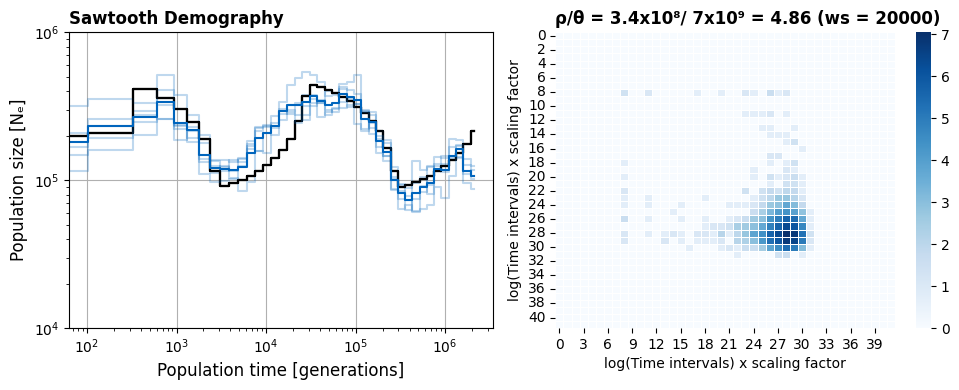

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]

y_preds = []
model_idx = 36
for seed in [1000, 2000, 3000, 4000, 5000]:

    model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L4_scaling3_diff_checkpoint_" + str(model_idx) + ".pth")['model'])
    
    model_idx += 1
    sawtooth_demography_object = create_sawtooth_demogaphy_object(Ne = 2*10**5, magnitue=8)

    # simulation of data
    params = {'discrete_genome': True, 'samples': 10, 
        'ploidy': 1, 'demography': sawtooth_demography_object,
        'recombination_rate': 3.4e-8, 'random_seed': seed,'sequence_length': 4_000_000
    }
    ts = msprime.sim_ancestry(**params)
    ts = msprime.mutate(ts, rate=7e-9)
    debugger = msprime.DemographyDebugger()
    debugger = msprime.DemographyDebugger(demography=sawtooth_demography_object)
    population_size = debugger.population_size_trajectory(population_time).flatten()

    # formatting of data for the model
    window_size = 20_000
    empirical_scaling_factor = np.exp(8.2)
    
    mutation_densities = obtain_mutation_densities(ts, window_size=window_size)
    tm = np.log(calculate_transition_matrix(np.log((mutation_densities.flatten()+1)*empirical_scaling_factor),
                                            np.log(population_time+1)) + 1)
    population_size_log = np.log(population_size)
    tm = torch.tensor(tm, dtype=torch.float32)
    print(tm.sum())
    population_size_log = torch.tensor(population_size_log, dtype=torch.float32)

    # loading it in dataloader and running hte inference
    inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)
    model.eval()
    total_loss = 0
    total_samples = 0 
    with torch.no_grad():
        for inputs, targets in inf_dl:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            print(loss)
            break

    # extractin the output
    y_true = targets.detach().cpu().numpy()
    y_pred = predictions.detach().cpu().numpy()

    # plotting it
    idx = 0
    sns.lineplot(x=population_time, y=np.exp(y_true[idx]), drawstyle="steps-mid", ax=ax, c="black", alpha=0.75)
    sns.lineplot(x=population_time, y=np.exp(y_pred[idx]), drawstyle="steps-mid", ax=ax, c="#0065bd", alpha=0.25)
    ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
    y_preds.append(y_pred[idx])

    ax.set_ylabel("Population size [Nₑ]", fontsize=12)
    ax.set_xlabel("Population time [generations]", fontsize=12)
    ax.set_title(f"Sawtooth Demography", loc="left", fontsize=12, fontweight='bold')
    ax.grid(True)
    print(f"TM sum: {tm.sum()}")

sns.lineplot(x=population_time, y=np.exp(np.array(y_preds).mean(0)), drawstyle="steps-mid", ax=ax, c="#0065bd")


ax = axs[1]
ax_labels = [f'Time {i}' for i in range(1, len(population_time) + 1)]
sns.heatmap(tm, cmap="Blues", annot=False, fmt=".2f", linewidths=.5, ax=ax)
ax.set_xlabel("log(Time intervals) x scaling factor")
ax.set_ylabel("log(Time intervals) x scaling factor")
ax.set_title(f"ρ/θ = 3.4x10⁸/ 7x10⁹ = 4.86 (ws = {window_size})", fontsize=12,  fontweight='bold', loc="left")
plt.tight_layout()
#plt.savefig("Sawtooth-10-Simulations-rhotheta-5-and-tm.png", dpi = 300)


y_preds_sawtooth = y_preds

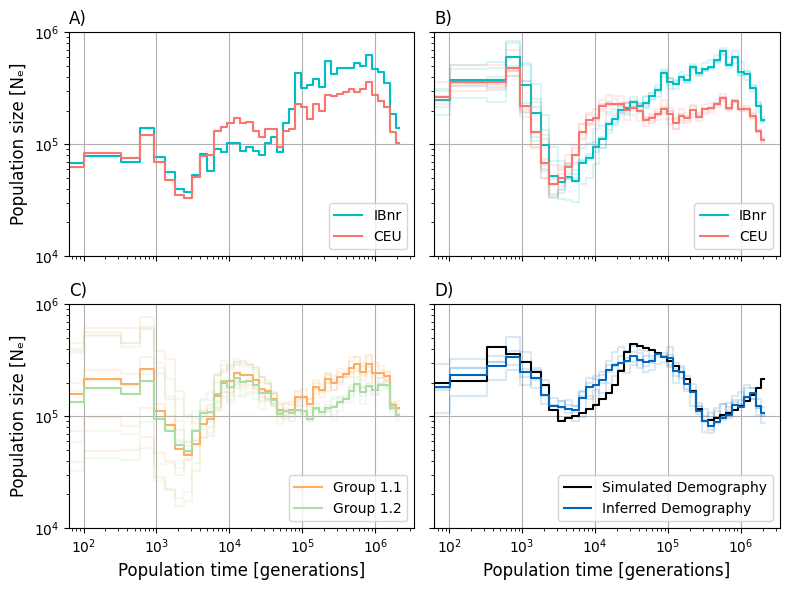

In [91]:

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)


ax = axs[0][0]
for i in range(1):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_snp[i]), drawstyle="steps-mid", ax=ax, c="#00BFC4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
#ax.set_title(f"$Arabidopsis$ $thaliana$ Demography:\nSNP (chromosomes 1)", loc="left", fontsize=12)
ax.set_title(f"A)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_snp.mean(0)), drawstyle="steps-mid", ax=ax, c="#00BFC4",  label="IBnr")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(1):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_snp[i]), drawstyle="steps-mid", ax=ax, c="#F8766D", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
#ax.set_title(f"A) $Arabidopsis$ $thaliana$ Demography:\nSNP (chromosomes 1)", loc="left", fontsize=12)
ax.set_title(f"A)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_snp.mean(0)), drawstyle="steps-mid", ax=ax, c="#F8766D",  label="CEU")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.legend(loc="lower right")

ax.grid()
plt.tight_layout()





ax = axs[0][1]
for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_smp[i]), drawstyle="steps-mid", ax=ax, c="#00BFC4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
#ax.set_title(f"$Arabidopsis$ $thaliana$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"B)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#00BFC4",  label="IBnr")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_smp[i]), drawstyle="steps-mid", ax=ax, c="#F8766D", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
#ax.set_title(f"B) $Arabidopsis$ $thaliana$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"B)", loc="left", fontsize=12)

ax.grid(True)
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#F8766D",  label="CEU")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.legend(loc="lower right")



ax = axs[1][0]
for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group11_smp[i]), drawstyle="steps-mid", ax=ax, c="#FDAE61", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
#ax.set_title(f"$Brachypodium$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"C)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group11_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#FDAE61",  label="Group 1.1")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group12_smp[i]), drawstyle="steps-mid", ax=ax, c="#ABDDA4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
#ax.set_title(f"C) $Brachypodium$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"C)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group12_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#ABDDA4",  label="Group 1.2")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.grid(True)
ax.legend(loc="lower right")


ax = axs[1][1]
for i in range(4):
    sns.lineplot(x=population_time, y=np.exp(y_preds_sawtooth[i]), drawstyle="steps-mid", ax=ax, c="#0065bd", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Population time [generations]", fontsize=12)
ax.set_title(f"D)", loc="left", fontsize=12)
ax.grid()
sns.lineplot(x=population_time, y=np.exp(np.array(y_true).mean(0)), drawstyle="steps-mid", ax=ax, c="black",  label="Simulated Demography")
sns.lineplot(x=population_time, y=np.exp(np.array(y_preds_sawtooth).mean(0)), drawstyle="steps-mid", ax=ax, c="#0065bd",  label="Inferred Demography")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.legend(loc="lower right")



ax.grid(True)
plt.tight_layout()

plt.savefig("Demographies_4panel_diff_L4.pdf", dpi = 400)

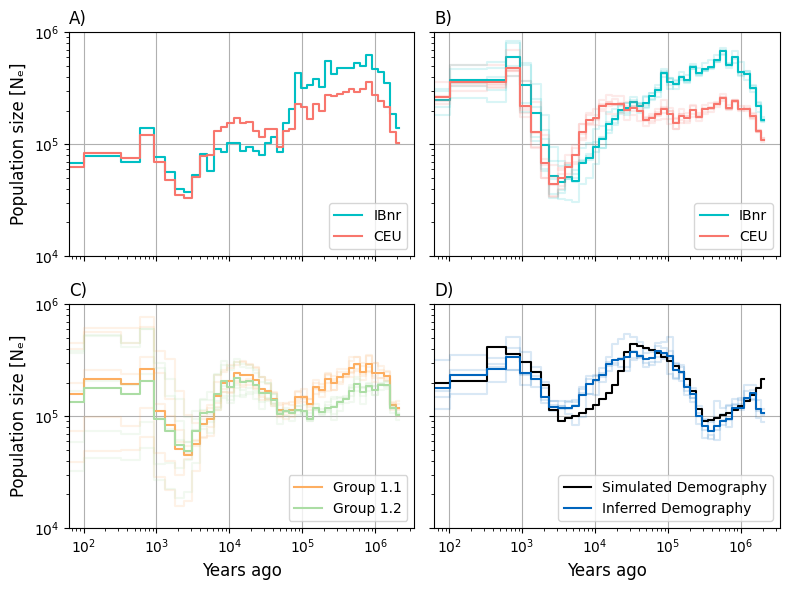

In [37]:

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)


ax = axs[0][0]
for i in range(1):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_snp[i]), drawstyle="steps-mid", ax=ax, c="#00BFC4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
#ax.set_title(f"$Arabidopsis$ $thaliana$ Demography:\nSNP (chromosomes 1)", loc="left", fontsize=12)
ax.set_title(f"A)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_snp.mean(0)), drawstyle="steps-mid", ax=ax, c="#00BFC4",  label="IBnr")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(1):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_snp[i]), drawstyle="steps-mid", ax=ax, c="#F8766D", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
#ax.set_title(f"A) $Arabidopsis$ $thaliana$ Demography:\nSNP (chromosomes 1)", loc="left", fontsize=12)
ax.set_title(f"A)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_snp.mean(0)), drawstyle="steps-mid", ax=ax, c="#F8766D",  label="CEU")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.legend(loc="lower right")

ax.grid()
plt.tight_layout()





ax = axs[0][1]
for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_smp[i]), drawstyle="steps-mid", ax=ax, c="#00BFC4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
#ax.set_title(f"$Arabidopsis$ $thaliana$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"B)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ibnr_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#00BFC4",  label="IBnr")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_smp[i]), drawstyle="steps-mid", ax=ax, c="#F8766D", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
#ax.set_title(f"B) $Arabidopsis$ $thaliana$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"B)", loc="left", fontsize=12)

ax.grid(True)
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_ceu_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#F8766D",  label="CEU")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.legend(loc="lower right")



ax = axs[1][0]
for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group11_smp[i]), drawstyle="steps-mid", ax=ax, c="#FDAE61", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
#ax.set_title(f"$Brachypodium$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"C)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group11_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#FDAE61",  label="Group 1.1")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

for i in range(5):
    sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group12_smp[i]), drawstyle="steps-mid", ax=ax, c="#ABDDA4", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
#ax.set_title(f"C) $Brachypodium$ Demography:\nSMP (chromosomes 1-5)", loc="left", fontsize=12)
ax.set_title(f"C)", loc="left", fontsize=12)

ax.grid()
sns.lineplot(x=population_time, y=np.exp(y_preds_chromosomes_group12_smp.mean(0)), drawstyle="steps-mid", ax=ax, c="#ABDDA4",  label="Group 1.2")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.grid(True)
ax.legend(loc="lower right")


ax = axs[1][1]
for i in range(4):
    sns.lineplot(x=population_time, y=np.exp(y_preds_sawtooth[i]), drawstyle="steps-mid", ax=ax, c="#0065bd", alpha=0.15)
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.set_ylabel("Population size [Nₑ]", fontsize=12)
ax.set_xlabel("Years ago", fontsize=12)
ax.set_title(f"D)", loc="left", fontsize=12)
ax.grid()
sns.lineplot(x=population_time, y=np.exp(np.array(y_true).mean(0)), drawstyle="steps-mid", ax=ax, c="black",  label="Simulated Demography")
sns.lineplot(x=population_time, y=np.exp(np.array(y_preds_sawtooth).mean(0)), drawstyle="steps-mid", ax=ax, c="#0065bd",  label="Inferred Demography")
ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))
ax.legend(loc="lower right")



ax.grid(True)
plt.tight_layout()

plt.savefig("Demographies_4panel_diff_L4.pdf", dpi = 400)

In [ ]:
(442413, 2980)
(22026, 1096)
(4914, 1096)

In [45]:
np.exp(8.5)

4914.768840299134

In [61]:
model_idx = 26
model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L2_scaling3_diff_checkpoint_" + str(model_idx) + ".pth")['model'])


/tmp/ipykernel_408104/3993288295.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/model-dataset_60k_window20k_L2_scaling3_diff_

<All keys matched successfully>

tensor(250.9775)
tensor(0.0504, device='cuda:0')
TM sum: 250.9774932861328
tensor(239.6089)
tensor(0.0276, device='cuda:0')
TM sum: 239.60885620117188
tensor(242.0932)
tensor(0.0230, device='cuda:0')
TM sum: 242.09323120117188
tensor(253.2444)
tensor(0.0384, device='cuda:0')
TM sum: 253.24441528320312
tensor(251.4627)
tensor(0.0560, device='cuda:0')
TM sum: 251.46267700195312


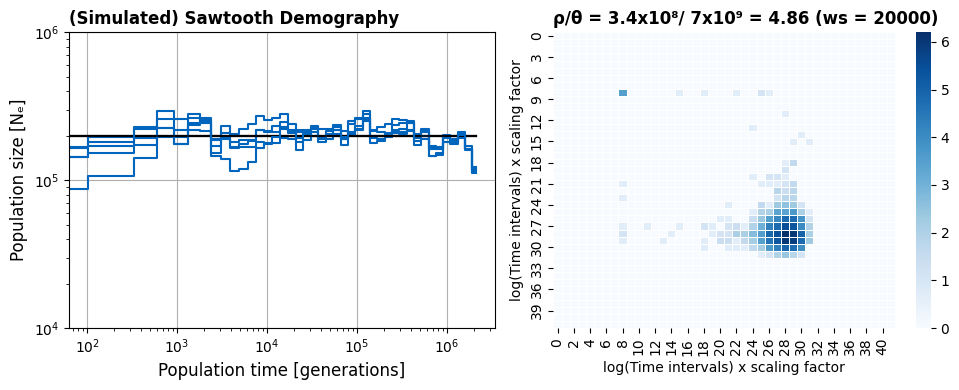

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]

for seed in [1000, 2000, 3000, 5000, 6000]:
    #sawtooth_demography_object = create_sawtooth_demogaphy_object(Ne = 2*10**5, magnitue=8)

    params = {
        'discrete_genome': True,
        'samples': 10, 
        'ploidy': 1,
        'population_size': 2*10**5,
        'recombination_rate': 3.4e-8,
        'random_seed': seed,
        'sequence_length': 2_000_000
    }
    ts = msprime.sim_ancestry(**params)
    ts = msprime.mutate(ts, rate=7e-9, random_seed=seed)

    #ts = msprime.mutate(ts, rate=7e-9*10)
    #ts = msprime.mutate(ts, rate=7e-9*100)

    #debugger = msprime.DemographyDebugger()
    #debugger = msprime.DemographyDebugger(demography=sawtooth_demography_object)
    population_size = [2*10**5]*42

    window_size = 20_000
    empirical_scaling_factor = np.exp(8.2)

    mutation_densities = obtain_mutation_densities(ts, window_size=window_size)
    tm = np.log(calculate_transition_matrix(np.log((mutation_densities.flatten()+1)*empirical_scaling_factor),
                                            np.log(population_time+1)) + 1)
    population_size_log = np.log(population_size)
    tm = torch.tensor(tm, dtype=torch.float32)
    print(tm.sum())
    population_size_log = torch.tensor(population_size_log, dtype=torch.float32)

    inf_dl = DataLoader([(tm, population_size_log)], batch_size=1)
    model.eval()
    total_loss = 0
    total_samples = 0 
    with torch.no_grad():
        for inputs, targets in inf_dl:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            print(loss)
            break

    y_true = targets.detach().cpu().numpy()
    y_pred = predictions.detach().cpu().numpy()

    idx = 0
    sns.lineplot(x=population_time, y=np.exp(y_true[idx]), drawstyle="steps-mid", ax=ax, c="black", alpha=0.75)
    sns.lineplot(x=population_time, y=np.exp(y_pred[idx]), drawstyle="steps-mid", ax=ax, c="#0065bd")
    ax.set(yscale="log", xscale="log", ylim=(10000, 1_000_000))

    ax.set_ylabel("Population size [Nₑ]", fontsize=12)
    ax.set_xlabel("Population time [generations]", fontsize=12)
    ax.set_title(f"(Simulated) Sawtooth Demography", loc="left", fontsize=12, fontweight='bold')

    #plt.savefig("IBNR-CEU-chr1-5-SMP.png", dpi = 200)
    ax.grid(True)
    plt.tight_layout()
    print(f"TM sum: {tm.sum()}")

ax = axs[1]
ax_labels = [f'Time {i}' for i in range(1, len(population_time) + 1)]
sns.heatmap(tm, cmap="Blues", annot=False, fmt=".2f", linewidths=.5, ax=ax)
ax.set_xlabel("log(Time intervals) x scaling factor")
ax.set_ylabel("log(Time intervals) x scaling factor")
ax.set_title(f"ρ/θ = 3.4x10⁸/ 7x10⁹ = 4.86 (ws = {window_size})", fontsize=12,  fontweight='bold', loc="left")
 
plt.tight_layout()
#plt.savefig("Sawtooth-10-Simulations-rhotheta-5-and-tm.png", dpi = 300)

In [ ]:
hlines = [
    [13, 8], 
    [10, 7],  
    [9, 7]    # for the third figure
]

In [42]:
np.exp(13),np.exp(8)

(442413.3920089205, 2980.9579870417283)

In [43]:
np.exp(10),np.exp(7)

(22026.465794806718, 1096.6331584284585)

In [44]:
np.exp(9),np.exp(7)

(8103.083927575384, 1096.6331584284585)

In [ ]:
(442413.3920089205, 2980.9579870417283)
(22026.465794806718, 1096.6331584284585)
(8103.083927575384, 1096.6331584284585)


In [90]:
np.save("seq_samples_snp_ibnr.npy", seq_samples_snp_ibnr)
np.save("seq_samples_snp_ceu.npy", seq_samples_snp_ceu)

np.save("seq_samples_ibnr.npy", seq_samples_ibnr)
np.save("seq_samples_ceu.npy", seq_samples_ceu)

np.save("seq_samples_11.npy", seq_samples_11)
np.save("seq_samples_12.npy", seq_samples_12)

In [91]:
seq_samples_snp_ibnr = np.load("seq_samples_snp_ibnr.npy")
seq_samples_snp_ceu = np.load("seq_samples_snp_ceu.npy")

seq_samples_ibnr = np.load("seq_samples_ibnr.npy")
seq_samples_ceu = np.load("seq_samples_ceu.npy")

seq_samples_11 = np.load("seq_samples_11.npy")
seq_samples_12 = np.load("seq_samples_12.npy")

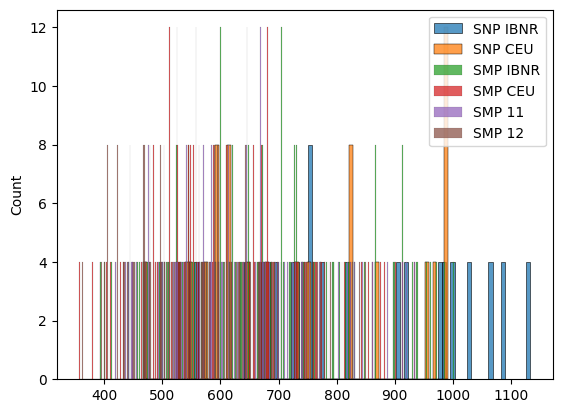

In [92]:
sns.histplot(seq_samples_snp_ibnr, label="SNP IBNR", bins=80)
sns.histplot(seq_samples_snp_ceu, label="SNP CEU", bins=80)

sns.histplot(seq_samples_ibnr, label="SMP IBNR", bins=400)
sns.histplot(seq_samples_ceu, label="SMP CEU", bins=400)

sns.histplot(seq_samples_11, label="SMP 11", bins=400)
sns.histplot(seq_samples_12, label="SMP 12", bins=400)

plt.legend()